## Example with CNN-LSTM on live BTC close price using the full data

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Mounted at /content/drive


In [ ]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.3 MB/s 
     |████████████████████████████████| 70 kB 8.2 MB/s 
     |████████████████████████████████| 1.1 MB 29.2 MB/s 
     |████████████████████████████████| 288 kB 88.0 MB/s 
     |████████████████████████████████| 112 kB 90.0 MB/s 
     |████████████████████████████████| 45 kB 3.4 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 144 kB 81.9 MB/s 
     |████████████████████████████████| 271 kB 96.9 MB/s 
     |████████████████████████████████| 749 kB 70.4 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [ ]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.sats2backtest as s2b
import src.timeutils as tu

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [ ]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (169719, 8)


### Generate Candles and build features from technical analysis

In [ ]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()

# Generate normalized timeseries

In [ ]:
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 50000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()

ts_btc.x_candles
ts_btc.x_time
ts_btc.y[-10:]

Candles Normalized
Extracted last 50000 steps
Generated time-series
Normalized 'candles_norm' with shape : (50000, 9)
Feature data 'x_candles' with size : 49952
Feature data with time intervals 'x_time' with size : 49952


[0.36666511884113395,
 0.36768276860463533,
 0.3676586407360366,
 0.36715432275804305,
 0.36725720763169045,
 0.367403704765937,
 0.3672613048169242,
 0.3673342347140848,
 0.36736546437042206,
 0.3676952422574581]

## Train CNN-LSTM model using full or part of data set

In [ ]:
btc_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 0.95)
btc_model.sats2model()

In [ ]:
datetime.strptime(str(can_btc.candles.index[-1]), '%Y-%m-%d %H:%M:%S').strftime('%y%m%d_%H_%M')

'220625_20_46'

In [ ]:
MODELDATE_TO_SAVE = datetime.strptime(str(can_btc.candles.index[-1]), '%Y-%m-%d %H:%M:%S').strftime('%y%m%d_%H_%M')
PRESAVED_MODELDATE = "220625_20_46"

if PRESAVED_MODELDATE == MODELDATE_TO_SAVE :
  model_name = f"model/LSTM_CNN_pretrained_{MODELDATE_TO_SAVE}"
else:
  model_name = "model/LSTM_CNN_model"

btc_model.sats2train(model_name, save_model = True, epochs=20)

Epoch 1/20
12/12 [==============================] - 25s 394ms/step - loss: 0.1961 - val_loss: 0.1660
Epoch 2/20
12/12 [==============================] - 1s 91ms/step - loss: 0.0539 - val_loss: 0.0518
Epoch 3/20
12/12 [==============================] - 1s 92ms/step - loss: 0.0349 - val_loss: 0.0210
Epoch 4/20
12/12 [==============================] - 1s 90ms/step - loss: 0.0172 - val_loss: 0.0190
Epoch 5/20
12/12 [==============================] - 1s 82ms/step - loss: 0.0551 - val_loss: 0.0291
Epoch 6/20
12/12 [==============================] - 1s 82ms/step - loss: 0.0271 - val_loss: 0.0500
Epoch 7/20
12/12 [==============================] - 1s 91ms/step - loss: 0.0165 - val_loss: 0.0059
Epoch 8/20
12/12 [==============================] - 1s 82ms/step - loss: 0.0348 - val_loss: 0.0077
Epoch 9/20
12/12 [==============================] - 1s 82ms/step - loss: 0.0556 - val_loss: 0.0744
Epoch 10/20
12/12 [==============================] - 1s 82ms/step - loss: 0.0471 - val_loss: 0.0105
Epoch 1

INFO:tensorflow:Assets written to: model/LSTM_CNN_pretrained_220625_20_46/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_pretrained_220625_20_46/assets


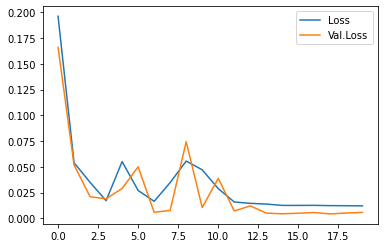

In [ ]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

### Retrain for longer

In [ ]:
btc_model.sats2train(model_name, save_model = True, epochs=500)

Epoch 1/500
12/12 [==============================] - 1s 95ms/step - loss: 0.0120 - val_loss: 0.0049
Epoch 2/500
12/12 [==============================] - 1s 92ms/step - loss: 0.0117 - val_loss: 0.0052
Epoch 3/500
12/12 [==============================] - 1s 82ms/step - loss: 0.0119 - val_loss: 0.0053
Epoch 4/500
12/12 [==============================] - 1s 91ms/step - loss: 0.0116 - val_loss: 0.0047
Epoch 5/500
12/12 [==============================] - 1s 91ms/step - loss: 0.0116 - val_loss: 0.0052
Epoch 6/500
12/12 [==============================] - 1s 94ms/step - loss: 0.0113 - val_loss: 0.0045
Epoch 7/500
12/12 [==============================] - 1s 82ms/step - loss: 0.0113 - val_loss: 0.0053
Epoch 8/500
12/12 [==============================] - 1s 91ms/step - loss: 0.0111 - val_loss: 0.0045
Epoch 9/500
12/12 [==============================] - 1s 91ms/step - loss: 0.0110 - val_loss: 0.0052
Epoch 10/500
12/12 [==============================] - 1s 93ms/step - loss: 0.0110 - val_loss: 0.0043

INFO:tensorflow:Assets written to: model/LSTM_CNN_pretrained_220625_20_46/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_pretrained_220625_20_46/assets


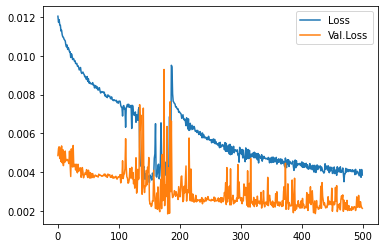

In [ ]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [ ]:
btc_model.sats2pred()

In [ ]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(btc_model.scaler, ts_btc.candles, btc_model.preds)

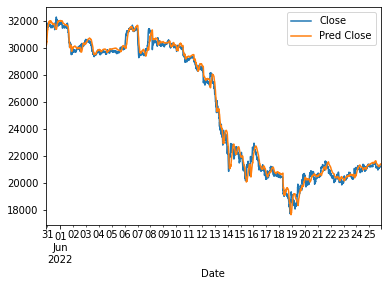

In [ ]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = 1)
df_preds_true.dropna().plot()

## Test on pretrained model

In [ ]:
USE_PRETRAINED = True

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 0.95)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = True)
loaded_model.preds

array([[0.44991258],
       [0.44996652],
       [0.45075148],
       ...,
       [0.36898786],
       [0.3691395 ],
       [0.36911604]], dtype=float32)

In [ ]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(loaded_model.scaler, ts_btc.candles, loaded_model.preds)

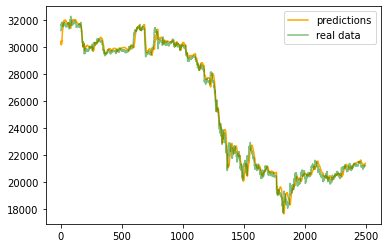

In [ ]:
plt.plot(preds, color='orange', label='predictions')
plt.plot(true_vals[btc_model.split_point+ts_btc.step_back:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

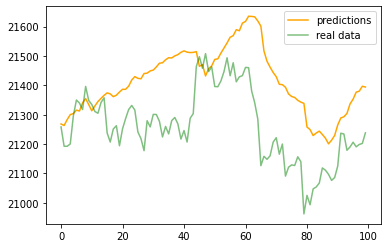

In [ ]:
plt.plot(preds[-100:], color='orange', label='predictions')
plt.plot(true_vals[-100:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

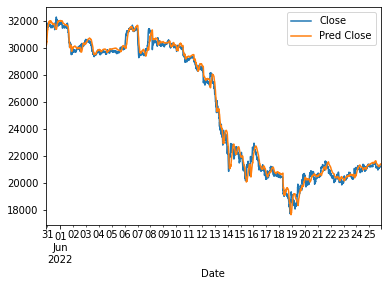

In [ ]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = 1)
df_preds_true.dropna().plot()

In [ ]:
df_preds_true.dropna()

,Close,Pred Close
Date,,
2022-05-30 20:46:00,31277.18,30268.273296
2022-05-30 21:01:00,31338.42,30274.197849
2022-05-30 21:16:00,31682.01,30360.411553
2022-05-30 21:31:00,31603.72,30478.748774
2022-05-30 21:46:00,31807.98,30175.529490
...,...,...
2022-06-25 19:46:00,21206.20,21336.505380
2022-06-25 20:01:00,21190.56,21352.953380
2022-06-25 20:16:00,21198.57,21376.772702


In [ ]:
np.array(true_vals[btc_model.split_point+ts_btc.step_back+1:])

array([31277.18, 31338.42, 31682.01, ..., 21198.57, 21202.  , 21238.22])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


Fee: 0.025
----------------------
Buy      313 ( 183 ok 130 ko )
Avg PCT gain: 1.005333214197155
Avg PCT loss: 0.9958874861429964
Wins  PCT   0.5846645367412141
Avg PCT Gain.    1.005333214197155
No-op    0
Wallet   8434.542250000006
Drawback -927.1227499999984
Kelly Fraction    0.1732314073373018
Total earned 8434.542250000006


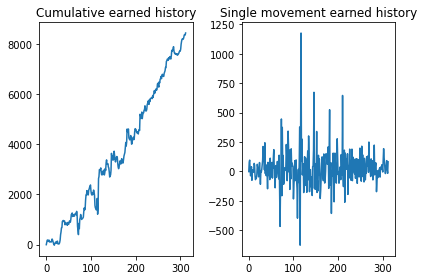

In [ ]:
total_wallet_history, single_wallet_history, wallet, kelly_frac = s2b.backtest_df(df_preds_true.dropna(), ts_btc.step_back, long_short = "long", fee=0.025)
s2b.show_backtest_results(wallet,total_wallet_history,single_wallet_history)

Fee: 0.025
----------------------
Buy      345 ( 200 ok 145 ko )
Wallet   9212.246749999997
Drawback -927.1227499999984
Total earned 9212.246749999997


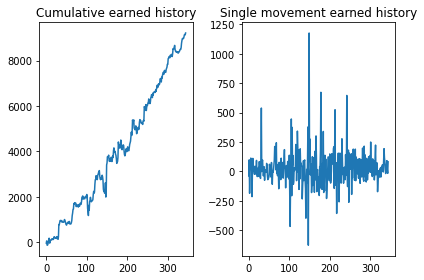

In [ ]:
total_wallet_history, single_wallet_history, wallet = s2b.backtest_debug(preds, true_vals, btc_model.split_point, ts_btc.step_back, fee=0.025)
s2b.show_backtest_results(wallet,total_wallet_history,single_wallet_history)